In [1]:
import numpy as np
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**DATASET CREATION**

In [2]:
#function to generate a sample
def generate_sample():
    seq_length = np.random.randint(2, 20)  # random sequence length between 2 and 19
    seq = torch.zeros((seq_length,2),dtype=torch.float)       # initialize sequence with zeros
    rand_indices = np.random.choice(seq_length, size=2, replace=False)  # select two random indices
    seq[rand_indices,1] = 1              # mark the selected indices with 1 in the second dimension
    seq[:,0] = torch.rand(seq_length,dtype=torch.float) # assign random values between 0 and 1 in the first dimension
    sum_val = torch.sum(seq[rand_indices,0])  # compute the sum of the random values at the marked indices
    return seq, sum_val

#function to generate a training dataset of required number of samples
def generate_dataset(input_size):
 dataset_x = []
 dataset_y = []
 dataset_y=[]
 for _ in range(input_size):
    seq, sum_val = generate_sample()
    dataset_x.append(seq)
    dataset_y.append(sum_val)
 return dataset_x,dataset_y
 

In [3]:
data_size=5000 #number of samples in dataset

X,Y=generate_dataset(data_size)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.01,random_state=42)
test_size=len(Y_test)
train_size=len(Y_train)
print(test_size,train_size)


50 4950


In [4]:
#sigmoid function
def sigmoid(x):
    return 1/(1+torch.exp(-x))

#tanh function
def tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

#MSE_loss function
def MSE_loss(ypred,y):
    return torch.mean((ypred-y)**2)



**TRAIN AND TEST FUNCTION**

In [5]:
def train_rnn(model,trainX,trainY,trainsize,learningrate,epochs):
    #choose gradient descent 
    optimizer = torch.optim.SGD(model.parameters(),lr=learningrate)
    Loss_epochs=[]
    for epoch in range(epochs):
        #training 
        loss_item=0
        for i in range(trainsize):
            ypred=model(trainX[i])
            loss=MSE_loss(ypred,trainY[i]) #calculate MSE loss
            optimizer.zero_grad()  #makes all gradients 0
            loss.backward()  #backpropagation
            optimizer.step()  #updates weights
            loss_item+=loss.item()
        print(f"Training Epoch {epoch+1}/{epochs}, Loss: {loss_item/train_size}")
        Loss_epochs.append(loss_item/train_size)

    return Loss_epochs
        


def test_rnn(model,testX,testsize):
        #testing
        test_ypred=[]
        for i in range(testsize):
              ypred=model(testX[i]).item()
              test_ypred.append(ypred)
        return test_ypred


**BASELINE**

In [6]:
#baseline
epochs=10
base_y=[1 for i in range(test_size)] #predicts y=1 always
x_axis=[i for i in range(test_size)]
x_axis_loss=[i for i in range(1,epochs+1)]


**ELMON NETWORK**

In [7]:
class ElmonRNN(nn.Module):
    def __init__(self,input_size, output_size, hidden_size):
        super(ElmonRNN,self).__init__()
        
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size

        #initialize weights(parameters)
        self.wxh=nn.parameter.Parameter(torch.randn(hidden_size,input_size),requires_grad=True)
        self.whh=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size),requires_grad=True)
        self.why=nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad=True)
        self.bh=nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad=True)
        self.by=nn.parameter.Parameter(torch.randn(output_size,1),requires_grad=True)
        

    
    def forward(self,X):
        h=torch.zeros((self.hidden_size,1),requires_grad=True)
        n=len(X)
        #calculate ht 
        for i in range(n):
            ht=tanh(self.wxh@X[i].reshape(-1,1)+self.whh@h+self.bh)
        #calculate predicted y
        y=self.why@ht+self.by
        return y

In [8]:
elmon=ElmonRNN(2,1,10)
Loss_epochs_elmon=train_rnn(elmon,X_train,Y_train,train_size,0.001,epochs)
ypred_elmon=test_rnn(elmon,X_test,test_size)


Training Epoch 1/10, Loss: 0.24171363648035807
Training Epoch 2/10, Loss: 0.15214060682557784
Training Epoch 3/10, Loss: 0.15082027281783025
Training Epoch 4/10, Loss: 0.1499904800434115
Training Epoch 5/10, Loss: 0.14939790893791635
Training Epoch 6/10, Loss: 0.14896363693060813
Training Epoch 7/10, Loss: 0.1486389213852657
Training Epoch 8/10, Loss: 0.14839115282807666
Training Epoch 9/10, Loss: 0.1481982394691893
Training Epoch 10/10, Loss: 0.14804492576353795


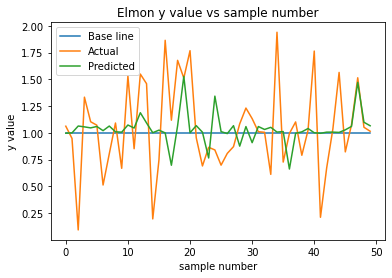

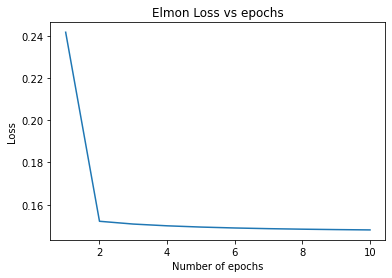

In [9]:
#plot learning and performance curves for elmon network(predicted values)
plt.plot(x_axis,base_y)
plt.plot(x_axis,Y_test)
plt.plot(x_axis,ypred_elmon)
plt.title("Elmon y value vs sample number")
plt.legend(["Base line","Actual","Predicted"])
plt.xlabel("sample number")
plt.ylabel("y value")
plt.show()

#plot learning loss curve for elmon (loss)
plt.plot(x_axis_loss,Loss_epochs_elmon)
plt.title("Elmon Loss vs epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.show()



**LSTM**

In [10]:
class LSTM(nn.Module):
    def __init__(self,input_size, output_size, hidden_size):
        super(LSTM,self).__init__()
        
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size

        #initialize weights(parameters)
        self.wf=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.bf=nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad=True)
        self.wi=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.bi=nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad=True)
        self.wc=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.bc=nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad=True)
        self.wo=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.bo=nn.parameter.Parameter(torch.randn(hidden_size,1),requires_grad=True)
        self.wy=nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad=True)
        self.by=nn.parameter.Parameter(torch.randn(output_size,1),requires_grad=True)



    def forward(self,X):
        ht=torch.zeros((self.hidden_size,1),requires_grad=True)
        ct=torch.zeros((self.hidden_size,1),requires_grad=True)
        n=len(X)
        for j in range(n):
            concat = torch.cat((ht,X[j].reshape(-1,1)),axis=0)
            # Compute values for ft, it, (c_tida)t, ct, ot, ht using the formulas given 
            ft = sigmoid(self.wf@concat + self.bf)
            it = sigmoid(self.wi@concat + self.bi)
            c_tildat = tanh(self.wc@concat + self.bc)
            ct = torch.mul(ft,ct) + torch.mul(it,c_tildat)
            ot = sigmoid(self.wo@concat + self.bo)
            ht = torch.mul(ot,tanh(ct))
            # Compute prediction of the LSTM cell 
            
        #compute output y
        y= (self.wy@ht) + self.by
        return y


In [11]:
lstm=LSTM(2,1,10)
Loss_epochs_lstm=train_rnn(lstm,X_train,Y_train,train_size,0.001,epochs)
ypred_lstm=test_rnn(lstm,X_test,test_size)


Training Epoch 1/10, Loss: 0.18204476768499597
Training Epoch 2/10, Loss: 0.1500689565978885
Training Epoch 3/10, Loss: 0.13869359266966358
Training Epoch 4/10, Loss: 0.12899290097303218
Training Epoch 5/10, Loss: 0.11955211882833347
Training Epoch 6/10, Loss: 0.10974017814409331
Training Epoch 7/10, Loss: 0.09839470075613817
Training Epoch 8/10, Loss: 0.08553975265001029
Training Epoch 9/10, Loss: 0.07161142153306124
Training Epoch 10/10, Loss: 0.057217157104388294


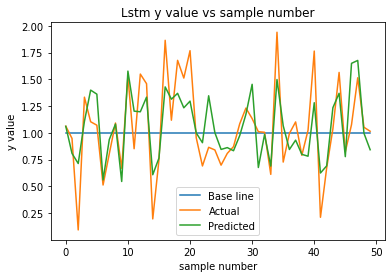

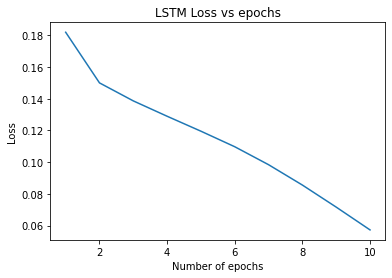

In [12]:
#plot learning and performance curves for lstm network
plt.plot(x_axis,base_y)
plt.plot(x_axis,Y_test)
plt.plot(x_axis,ypred_lstm)
plt.title("Lstm y value vs sample number")
plt.legend(["Base line","Actual","Predicted"])
plt.xlabel("sample number")
plt.ylabel("y value")
plt.show()


#plot learning loss curve for LSTM (loss)
plt.plot(x_axis_loss,Loss_epochs_lstm)
plt.title("LSTM Loss vs epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.show()


**GRU**

In [13]:
class GRU(nn.Module):
    def __init__(self,input_size, output_size, hidden_size):
        super(GRU,self).__init__()
        
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size

        #initialize weights(parameters)
        self.wz=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.wr=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.w=nn.parameter.Parameter(torch.randn(hidden_size,hidden_size+input_size),requires_grad=True)
        self.wy=nn.parameter.Parameter(torch.randn(output_size,hidden_size),requires_grad=True)
        self.by=nn.parameter.Parameter(torch.randn((output_size,1)),requires_grad=True)



    def forward(self,X):
        ht=torch.zeros((self.hidden_size,1),requires_grad=True)
        n=len(X)
        for j in range(n):
            concat1 = torch.cat((ht,X[j].reshape(-1,1)),axis=0)            
            # Compute values for zt, rt, (h_tida)t, ht using the formulas given 
            zt = sigmoid(self.wz@concat1)
            rt = sigmoid(self.wr@concat1)
            concat2=torch.cat((torch.mul(rt,ht),X[j].reshape(-1,1)),axis=0)
            h_tildat = tanh(self.w@concat2)
            ht = torch.mul(1-zt,ht) + torch.mul(zt,h_tildat)
            
        # Compute prediction of the LSTM cell 
        y = (self.wy@ht) + self.by
        return y


In [14]:
gru=GRU(2,1,10)
Loss_epochs_gru=train_rnn(gru,X_train,Y_train,train_size,0.001,epochs)
ypred_gru=test_rnn(gru,X_test,test_size)

Training Epoch 1/10, Loss: 0.2892817998308344
Training Epoch 2/10, Loss: 0.14441481069798082
Training Epoch 3/10, Loss: 0.1211813057957077
Training Epoch 4/10, Loss: 0.10176553562498471
Training Epoch 5/10, Loss: 0.0855901091099143
Training Epoch 6/10, Loss: 0.07239401108782119
Training Epoch 7/10, Loss: 0.061676495166272764
Training Epoch 8/10, Loss: 0.053040661400306985
Training Epoch 9/10, Loss: 0.046091106931698926
Training Epoch 10/10, Loss: 0.040459403841985174


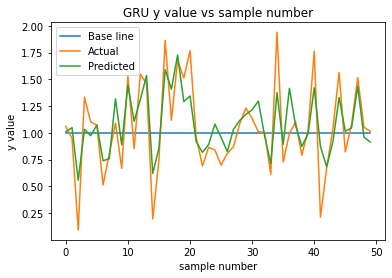

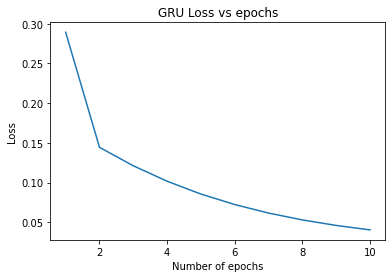

In [15]:
#plot learning and performance curves for GRU
plt.plot(x_axis,base_y)
plt.plot(x_axis,Y_test)
plt.plot(x_axis,ypred_gru)
plt.title("GRU y value vs sample number")
plt.legend(["Base line","Actual","Predicted"])
plt.xlabel("sample number")
plt.ylabel("y value")
plt.show()

#plot learning loss curve for GRU (loss)
plt.plot(x_axis_loss,Loss_epochs_gru)
plt.title("GRU Loss vs epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.show()


We observe that elmon predicts close to baseline whereas LSTM,GRU predict close to y values(ground truth) i.e elmon has high loss when compared to LSTM,GRU. LSTM,GRU predict better than Elmon.